In [1]:
# from: http://blog.yhat.com/posts/logistic-regression-python-rodeo.html

import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np

/Applications/anaconda3/envs/py2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
  # read the data in
  df = pd.read_csv("binary.csv")

In [3]:
df.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [4]:
# rename 'rank' column

df.columns = ["admit", "gre", "gpa", "prestige"]

In [5]:
df.columns

Index([u'admit', u'gre', u'gpa', u'prestige'], dtype='object')

In [6]:
# summarize the data
df.describe()

,admit,gre,gpa,prestige
count,400.000000,400.000000,400.000000,400.00000
mean,0.317500,587.700000,3.389900,2.48500
std,0.466087,115.516536,0.380567,0.94446
min,0.000000,220.000000,2.260000,1.00000
25%,0.000000,520.000000,3.130000,2.00000
50%,0.000000,580.000000,3.395000,2.00000
75%,1.000000,660.000000,3.670000,3.00000
max,1.000000,800.000000,4.000000,4.00000


In [7]:
# take a look at the standard deviation of each column.
df.std()

admit         0.466087
gre         115.516536
gpa           0.380567
prestige      0.944460
dtype: float64

In [8]:
# frequency table cutting prestige and whether or not someone was admitted
pd.crosstab(df['admit'], df['prestige'], rownames=['admit'])

prestige,1,2,3,4
admit,,,,
0,28,97,93,55
1,33,54,28,12


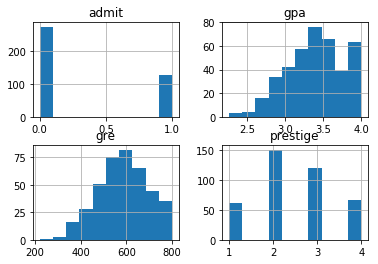

In [9]:
# plot all of the columns
df.hist()
pl.show()

In [10]:
# dummify rank i.e. prestige
dummy_ranks = pd.get_dummies(df['prestige'], prefix='prestige')
dummy_ranks.head()

,prestige_1,prestige_2,prestige_3,prestige_4
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,0,0,0,1
4,0,0,0,1


In [11]:
# create a clean data frame for the regression
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2':])
data.head()

/Applications/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


,admit,gre,gpa,prestige_2,prestige_3,prestige_4
0,0,380,3.61,0,1,0
1,1,660,3.67,0,1,0
2,1,800,4.00,0,0,0
3,1,640,3.19,0,0,1
4,0,520,2.93,0,0,1


In [12]:
# manually add the intercept
data['intercept'] = 1.0

In [13]:
data.head()

,admit,gre,gpa,prestige_2,prestige_3,prestige_4,intercept
0,0,380,3.61,0,1,0,1.0
1,1,660,3.67,0,1,0,1.0
2,1,800,4.00,0,0,0,1.0
3,1,640,3.19,0,0,1,1.0
4,0,520,2.93,0,0,1,1.0


In [14]:
# Performing the regression
# NOTE: we'll be predicting the admit column using gre, gpa, and the 
# prestige dummy variables prestige_2, prestige_3 and prestige_4. 
# We're going to treat prestige_1 as our baseline and exclude it from our fit. 
# This is done to prevent multicollinearity, or the dummy variable trap caused 
# by including a dummy variable for every single category.

train_cols = data.columns[1:]

# Index([gre, gpa, prestige_2, prestige_3, prestige_4], dtype=object)

logit = sm.Logit(data['admit'], data[train_cols])

# fit the model
  
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.573147
         Iterations 6


In [15]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      394
Method:                           MLE   Df Model:                            5
Date:                Fri, 09 Feb 2018   Pseudo R-squ.:                 0.08292
Time:                        14:17:54   Log-Likelihood:                -229.26
converged:                       True   LL-Null:                       -249.99
                                        LLR p-value:                 7.578e-08
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
gre            0.0023      0.001      2.070      0.038       0.000       0.004
gpa            0.8040      0.332      2.423      0.015       0.154       1.454
prestige_2    -0.6754      0.316     -2.134      0.033      -1.296      -0.055
prestige_3    -1.3402      0.345     -3.881      0.000      -2.017      -0.663
prestige_4    -1.5515      0.418     -3.713      0.000      -2.370      -0.733
intercept     -3.9900      1.140     -3.500      0.000      -6.224      -1.756
==============================================================================
"""

In [16]:
# look at the confidence interval of each coeffecient
result.conf_int()

,0,1
gre,0.000120,0.004409
gpa,0.153684,1.454391
prestige_2,-1.295751,-0.055135
prestige_3,-2.016992,-0.663416
prestige_4,-2.370399,-0.732529
intercept,-6.224242,-1.755716


In [17]:
# odds ratios only
# NOTE: Take the exponential of each of the coefficients to generate the odds ratios. 
# This tells you how a 1 unit increase or decrease in a variable affects the odds of 
# being admitted. For example, we can expect the odds of being admitted to decrease by
# about 50% if the prestige of a school is 2.
# more info about odds ratio here: https://stats.idre.ucla.edu/?s=odds+ratio



np.exp(result.params)

gre           1.002267
gpa           2.234545
prestige_2    0.508931
prestige_3    0.261792
prestige_4    0.211938
intercept     0.018500
dtype: float64

In [18]:
# odds ratios and 95% CI
params = result.params
conf = result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
np.exp(conf)

,2.5%,97.5%,OR
gre,1.000120,1.004418,1.002267
gpa,1.166122,4.281877,2.234545
prestige_2,0.273692,0.946358,0.508931
prestige_3,0.133055,0.515089,0.261792
prestige_4,0.093443,0.480692,0.211938
intercept,0.001981,0.172783,0.018500


In [19]:
# Digging a little deeper. See section in: http://blog.yhat.com/posts/logistic-regression-python-rodeo.html

# ------------ #

# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max
  
gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)
gres
gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)
gpas


#define the cartesian function
def cartesian(arrays, out=None):
    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

# enumerate all possibilities

combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]))
  
# recreate the dummy variables
combos.columns = ['gre', 'gpa', 'prestige', 'intercept']
dummy_ranks = pd.get_dummies(combos['prestige'], prefix='prestige')
dummy_ranks.columns = ['prestige_1', 'prestige_2', 'prestige_3', 'prestige_4']

# keep only what we need for making predictions
cols_to_keep = ['gre', 'gpa', 'prestige', 'intercept']
combos = combos[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2':])

# make predictions on the enumerated dataset
combos['admit_pred'] = result.predict(combos[train_cols])

combos.head()

/Applications/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,gre,gpa,prestige,intercept,prestige_2,prestige_3,prestige_4,admit_pred
0,220.0,2.260000,1.0,1.0,0,0,0,0.157801
1,220.0,2.260000,2.0,1.0,1,0,0,0.087056
2,220.0,2.260000,3.0,1.0,0,1,0,0.046758
3,220.0,2.260000,4.0,1.0,0,0,1,0.038194
4,220.0,2.453333,1.0,1.0,0,0,0,0.179574


/Applications/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


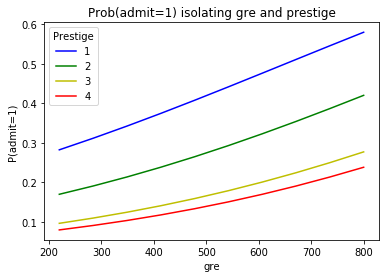

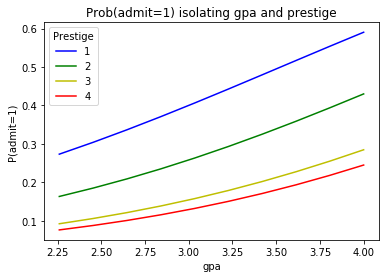

In [21]:
def isolate_and_plot(variable):
    # isolate gre and class rank
    grouped = pd.pivot_table(combos, values=['admit_pred'], index=[variable, 'prestige'],
                aggfunc=np.mean)
    # make a plot
    colors = 'rbgyrbgy'
    for col in combos.prestige.unique():
        plt_data = grouped.ix[grouped.index.get_level_values(1)==col]
        pl.plot(plt_data.index.get_level_values(0), plt_data['admit_pred'], color=colors[int(col)])

    pl.xlabel(variable)
    pl.ylabel("P(admit=1)")
    pl.legend(['1', '2', '3', '4'], loc='upper left', title='Prestige')
    pl.title("Prob(admit=1) isolating " + variable + " and prestige")
    pl.show()

isolate_and_plot('gre')
isolate_and_plot('gpa')